In [ ]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL, urllib
import os
from PIL import Image
import pandas as pd

In [ ]:
def get_diagnosis(image_name, file):

    matching_row = file[file['image_id'] == image_name.split('.')[0]]
    if not matching_row.empty:
        return matching_row.iloc[0]['dx']
    return None

def create_image_diagnosis_dict(base_path, folders, file):
    metadata = pd.read_csv(file)

    image_diagnosis_dict = {}
    for folder in folders:
        path = base_path + folder
        for image_name in os.listdir(path):
            diagnosis = get_diagnosis(image_name, metadata)
            if diagnosis is not None:

                image_diagnosis_dict[image_name] = diagnosis
    return image_diagnosis_dict

In [ ]:
class diagnoses(Dataset):
        CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc')

        def __init__(self, data, transform=None):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            image_path, label = self.data[idx]
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
            try:
                label_idx = self.CLASSES.index(label) if isinstance(label, str) else label
            except ValueError:
                print(f"Error with label: {label} at index: {idx}")
                raise
            return image, label_idx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/Skin Cancer Detection - APS360/data'
folders = ('/HAM10000_images_part_1', '/HAM10000_images_part_2')
metadata = '/HAM10000_metadata.csv'

dataset = []

matches = create_image_diagnosis_dict(base_path, folders, base_path + metadata)

In [ ]:
def make_dataset(idx, base_path, folders, max_images=None):
    CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc')
    dataset = []
    image_count = 0
    for folder in folders:
        path = base_path + folder
        for img in sorted(os.listdir(path)):
            if max_images and image_count >= 200000:
                break
            image_path = os.path.join(path, img)
            label = idx.get(img)
            if label is None or label not in CLASSES:
                continue
            dataset.append((image_path, label))
            image_count += 1
        if max_images and image_count >= max_images:
            break
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

def get_data_loader(batch_size, idx, base_path, folders):

    transform = transforms.Compose([
        transforms.Resize((250,250)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = make_dataset(idx, base_path, folders, 50000)

    labels = [label for _, label in dataset]

    train_indices, val_indices = train_test_split(
        range(len(dataset)),
        test_size=0.3,  # 30% for validation
        stratify=labels
    )

    train_set = [dataset[i] for i in train_indices]
    validation_set = [dataset[i] for i in val_indices]

    label_counts_train = Counter(label for _, label in train_set)
    label_counts_validation = Counter(label for _, label in validation_set)

    class_weights = {label: 1.0 / count for label, count in label_counts_train.items()}
    sample_weights = [class_weights[label] for _, label in train_set]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    for label, count in label_counts_train.items():
     print(f"Train - {label}: {count}")

    for label, count in label_counts_validation.items():
     print(f"Val - {label}: {count}")

    #declare pytorch dataset
    torch_train = diagnoses(train_set, transform)
    torch_validation = diagnoses(validation_set, transform)


    #create loaders
    train_loader = torch.utils.data.DataLoader(torch_train, batch_size=batch_size, sampler=sampler,
                              num_workers=0)
    val_loader = torch.utils.data.DataLoader(torch_validation, batch_size=batch_size,
                                              num_workers=0, shuffle = False)#change num workers later
    print("get data loader complete")

    return train_loader, val_loader


In [ ]:
train_loader, val_loader = get_data_loader(128, matches, base_path, folders)

Train - mel: 779
Train - nv: 4693
Train - bkl: 769
Train - akiec: 229
Train - bcc: 360
Train - df: 81
Train - vasc: 99
Val - nv: 2012
Val - bkl: 330
Val - mel: 334
Val - bcc: 154
Val - vasc: 43
Val - akiec: 98
Val - df: 34
get data loader complete


In [ ]:
len(train_loader)

55

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):

    path = "{0}_batch_{1}_lr_{2}_epoch_{3}.model".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_epoch += labels.size(0)
    avg_err = total_err / total_epoch
    avg_loss = total_loss / len(loader)
    net.train()
    return avg_err, avg_loss

In [ ]:


def train_net(net, train_loader, val_loader, batch_size=64, learning_rate=0.01, num_epochs=30, step_size=2):
    torch.manual_seed(1000)

    # Move the model to GPU if available
    if torch.cuda.is_available():
        net = net.cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            print(f"{i} batch initiated")
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            main_outputs, aux_outputs = net(inputs)  # Adjusted to receive two outputs
            loss_main = criterion(main_outputs, labels)
            loss_aux = criterion(aux_outputs, labels)

            # Weighting the main and auxiliary losses. Adjust the weighting as needed.
            total_loss = loss_main + 0.1 * loss_aux  # Example weighting

            total_loss.backward()
            optimizer.step()

            _, predicted = torch.max(main_outputs.data, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += total_loss.item()
            total_epoch += labels.size(0)

        train_err[epoch] = total_train_err / total_epoch
        train_loss[epoch] = total_train_loss / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | "
              f"Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")

        model_path = f"{net.name}_batch_{batch_size}_lr_{learning_rate}_epoch_{epoch}.model"
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    print(f"Total time elapsed: {(end_time - start_time):.2f} seconds")

    # Write training and validation errors and losses to CSV files
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)

# Ensure evaluate function handles the two outputs correctly
def evaluate(net, data_loader, criterion):
    net.eval()  # Set the model to evaluation mode

    # Move the model to GPU if available
    if torch.cuda.is_available():
        net = net.cuda()
    total_err = 0.0
    total_loss = 0.0
    total_epoch = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            main_outputs, aux_outputs = net(inputs)
            loss_main = criterion(main_outputs, labels)
            # For validation, only the main loss is typically considered
            total_err += (main_outputs.max(1)[1] != labels).sum().item()
            total_loss += loss_main.item()
            total_epoch += labels.size(0)

    return total_err / total_epoch, total_loss / (i+1)

In [ ]:
def plot_training_curve(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    plt.figure(figsize=(4, 4))

    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1, n+1), train_err, label="Train")
    plt.plot(range(1, n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(4, 4))

    plt.title("Train vs Validation Loss")
    plt.plot(range(1, n+1), train_loss, label="Train")
    plt.plot(range(1, n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0, 3.5)
    plt.legend(loc='best')
    plt.show()

In [ ]:
######################################################
##############  Primary Model 5.0  ###################
######################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, f1, f2, f3, f4, f5, f6):
        super(InceptionBlock, self).__init__()
        self.name = 'InceptionBlock'
        # Total output channels from all paths
        out_channels = f1 + f3 + f5 + f6


        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1)
        self.conv3_1 = nn.Conv2d(in_channels, f2, kernel_size=1)
        self.conv3_2 = nn.Conv2d(f2, f3, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(in_channels, f4, kernel_size=5, padding=2)
        self.conv5_2 = nn.Conv2d(f4, f5, kernel_size=5, padding=2)  # Additional 5x5 conv for depth
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_conv = nn.Conv2d(in_channels, f6, kernel_size=1)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        res = self.res_conv(x)

        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv3_1(x))
        x2 = F.relu(self.conv3_2(x2))
        x3 = F.relu(self.conv5_1(x))
        x3 = F.relu(self.conv5_2(x3))
        x4 = self.pool(x)
        x4 = F.relu(self.pool_conv(x4))

        out = torch.cat([x1, x2, x3, x4], dim=1)
        out += res  # Adding the residual connection
        return F.relu(out)

class AuxModel(nn.Module):
    def __init__(self):
        super(AuxModel, self).__init__()
        self.name = 'AuxModel'
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.inception1 = InceptionBlock(64, 16, 24, 32, 16, 32, 32)
        self.inception2 = InceptionBlock(112, 32, 48, 64, 32, 64, 32)
        self.inception3 = InceptionBlock(192, 64, 96, 128, 64, 128, 64)

        self.dilated_conv = nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=2, dilation=2)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Main classification layer
        self.fc1 = nn.Linear(512, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, 50)
        self.fc4 = nn.Linear(50, 7)
        # Auxiliary branch
        self.auxiliary_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.auxiliary_fc1 = nn.Linear(192, 100)
        self.auxiliary_fc2 = nn.Linear(100, 7)  # Assuming the aux output has the same number of classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.inception1(x)
        x = self.maxpool(x)

        # Save the output after the second inception block for the auxiliary branch
        aux = self.inception2(x)
        x = self.maxpool(aux)

        x = self.inception3(x)

        x = self.dilated_conv(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        main_output = self.fc4(x)


        # Auxiliary branch computations
        aux = self.auxiliary_avgpool(aux)
        aux = torch.flatten(aux, 1)
        aux = F.relu(self.auxiliary_fc1(aux))
        aux_output = self.auxiliary_fc2(aux)

        return main_output, aux_output

In [ ]:
primary_model = AuxModel()
if torch.cuda.is_available():
    primary_model.cuda()

bs = 128
lr = 0.001
epochs = 80

train_net(primary_model, train_loader, val_loader, batch_size=bs,learning_rate=lr,num_epochs=epochs)

0 batch initiated
1 batch initiated
2 batch initiated
3 batch initiated
4 batch initiated
5 batch initiated
6 batch initiated
7 batch initiated
8 batch initiated
9 batch initiated
10 batch initiated
11 batch initiated
12 batch initiated
13 batch initiated
14 batch initiated
15 batch initiated
16 batch initiated
17 batch initiated
18 batch initiated
19 batch initiated
20 batch initiated
21 batch initiated
22 batch initiated
23 batch initiated
24 batch initiated
25 batch initiated
26 batch initiated
27 batch initiated
28 batch initiated
29 batch initiated
30 batch initiated
31 batch initiated
32 batch initiated
33 batch initiated
34 batch initiated
35 batch initiated
36 batch initiated
37 batch initiated
38 batch initiated
39 batch initiated
40 batch initiated
41 batch initiated
42 batch initiated
43 batch initiated
44 batch initiated
45 batch initiated
46 batch initiated
47 batch initiated
48 batch initiated
49 batch initiated
50 batch initiated
51 batch initiated
52 batch initiated
53 

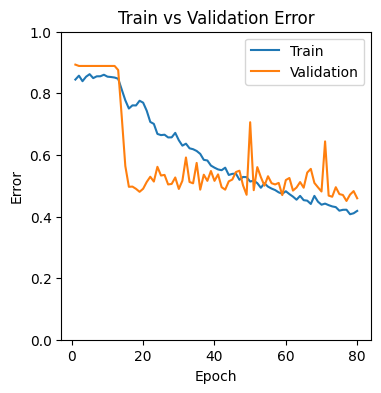

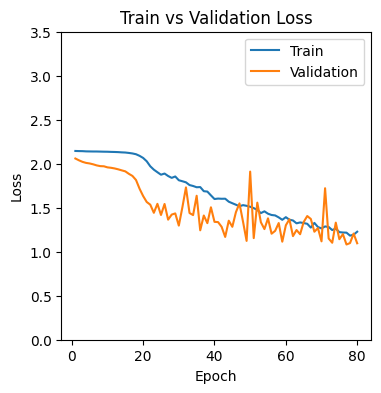

In [ ]:
path = get_model_name("AuxModel", batch_size=bs, learning_rate=lr, epoch=epochs-1)
plot_training_curve(path)

In [ ]:
torch.save(primary_model.state_dict(), 'Model5.pt')
from google.colab import files
files.download('Model5.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp Model5.pt /content/drive/MyDrive/<destination-folder-name>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `cp BigBoy.pt /content/drive/MyDrive/<destination-folder-name>'
